In [3]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import torch

from constants import SEED, MEMORY_CAPACITY, \
    NR_EPISODES, NR_NODES, MIN_EPSILON, \
    EPSILON_DECAY_RATE, N_STEP_QL, \
    BATCH_SIZE, GAMMA, DEVICE, FOLDER_NAME
from generate_graph import get_graph_mat
from memory import Memory, Experience
from state2tens import State, state2tens
from utils import init_model, is_state_final, get_next_neighbor_random, total_distance, checkpoint_model, moving_avg


### Hyperparameters

In [4]:
# seed everything for reproducible results first:
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Create module, optimizer, LR scheduler, and Q-function
Q_func, Q_net, optimizer, lr_scheduler = init_model()

# Create memory
memory = Memory(MEMORY_CAPACITY)

# Storing metrics about training:
found_solutions = dict()  # episode --> (coords, W, solution)
losses = []
path_lengths = []

# keep track of median path length for model checkpointing
current_min_med_length = float('inf')

Ep 0. Loss = -1.000 / median length = 3.487 / last = 3.4873 / epsilon = 1.0000 / lr = 0.0050
Ep 10. Loss = -1.000 / median length = 5.717 / last = 5.7169 / epsilon = 0.9940 / lr = 0.0050
Ep 20. Loss = -1.000 / median length = 4.974 / last = 4.3185 / epsilon = 0.9881 / lr = 0.0050
Ep 30. Loss = -1.000 / median length = 4.974 / last = 3.7427 / epsilon = 0.9822 / lr = 0.0050
Ep 40. Loss = -1.000 / median length = 4.974 / last = 5.0773 / epsilon = 0.9763 / lr = 0.0050
Ep 50 | current sol: [8, 5] / next est reward: 0.03770822286605835
Ep 50 | current sol: [8, 5, 7, 4] / next est reward: 0.1030026376247406
Ep 50. Loss = -1.000 / median length = 5.000 / last = 5.7980 / epsilon = 0.9704 / lr = 0.0050
Ep 60. Loss = -1.000 / median length = 5.036 / last = 6.1192 / epsilon = 0.9646 / lr = 0.0050
Ep 70. Loss = -1.000 / median length = 5.194 / last = 5.5106 / epsilon = 0.9589 / lr = 0.0050
Ep 80. Loss = -1.000 / median length = 5.270 / last = 6.1859 / epsilon = 0.9531 / lr = 0.0050
Ep 90. Loss = -1

### Training

In [ ]:
for episode in range(NR_EPISODES):
    # sample a new random graph
    coords, W_np = get_graph_mat(n=NR_NODES)
    W = torch.tensor(W_np, dtype=torch.float32, requires_grad=False, device=DEVICE)

    # current partial solution - a list of node index
    solution = [random.randint(0, NR_NODES-1)]

    # current state (tuple and tensor)
    current_state = State(partial_solution=solution, W=W, coords=coords)
    current_state_tsr = state2tens(current_state)

    # Keep track of some variables for insertion in replay memory:
    states = [current_state]
    states_tsrs = [current_state_tsr]  # we also keep the state tensors here (for efficiency)
    rewards = []
    actions = []

    # current value of epsilon
    epsilon = max(MIN_EPSILON, (1-EPSILON_DECAY_RATE)**episode)

    nr_explores = 0
    t = -1
    while not is_state_final(current_state):
        t += 1  # time step of this episode

        if epsilon >= random.random():
            # explore
            next_node = get_next_neighbor_random(current_state)
            nr_explores += 1
        else:
            # exploit
            next_node, est_reward = Q_func.get_best_action(current_state_tsr, current_state)
            if episode % 50 == 0:
                print('Ep {} | current sol: {} / next est reward: {}'.format(episode, solution, est_reward))

        next_solution = solution + [next_node]

        # reward observed for taking this step
        reward = -(total_distance(next_solution, W) - total_distance(solution, W))

        next_state = State(partial_solution=next_solution, W=W, coords=coords)
        next_state_tsr = state2tens(next_state)

        # store rewards and states obtained along this episode:
        states.append(next_state)
        states_tsrs.append(next_state_tsr)
        rewards.append(reward)
        actions.append(next_node)

        # store our experience in memory, using n-step Q-learning:
        if len(solution) >= N_STEP_QL:
            memory.remember(Experience(state=states[-N_STEP_QL],
                                       state_tsr=states_tsrs[-N_STEP_QL],
                                       action=actions[-N_STEP_QL],
                                       reward=sum(rewards[-N_STEP_QL:]),
                                       next_state=next_state,
                                       next_state_tsr=next_state_tsr))

        if is_state_final(next_state):
            for n in range(1, N_STEP_QL):
                memory.remember(Experience(state=states[-n],
                                           state_tsr=states_tsrs[-n],
                                           action=actions[-n],
                                           reward=sum(rewards[-n:]),
                                           next_state=next_state,
                                           next_state_tsr=next_state_tsr))

        # update state and current solution
        current_state = next_state
        current_state_tsr = next_state_tsr
        solution = next_solution

        # take a gradient step
        loss = None
        if len(memory) >= BATCH_SIZE and len(memory) >= 2000:
            experiences = memory.sample_batch(BATCH_SIZE)

            batch_states_tsrs = [e.state_tsr for e in experiences]
            batch_Ws = [e.state.W for e in experiences]
            batch_actions = [e.action for e in experiences]
            batch_targets = []

            for i, experience in enumerate(experiences):
                target = experience.reward
                if not is_state_final(experience.next_state):
                    _, best_reward = Q_func.get_best_action(experience.next_state_tsr,
                                                            experience.next_state)
                    target += GAMMA * best_reward
                batch_targets.append(target)

            # print('batch targets: {}'.format(batch_targets))
            loss = Q_func.batch_update(batch_states_tsrs, batch_Ws, batch_actions, batch_targets)
            losses.append(loss)

            """ Save model when we reach a new low average path length
            """
            med_length = np.median(path_lengths[-100:])
            if med_length < current_min_med_length:
                current_min_med_length = med_length
                checkpoint_model(Q_net, optimizer, lr_scheduler, loss, episode, med_length)

    length = total_distance(solution, W)
    path_lengths.append(length)

    if episode % 10 == 0:
        print('Ep %d. Loss = %.3f / median length = %.3f / last = %.4f / epsilon = %.4f / lr = %.4f' % (
            episode, (-1 if loss is None else loss), np.median(path_lengths[-50:]), length, epsilon,
            Q_func.optimizer.param_groups[0]['lr']))
        found_solutions[episode] = (W.clone(), coords.copy(), [n for n in solution])

Text(0.5, 0, 'episode')

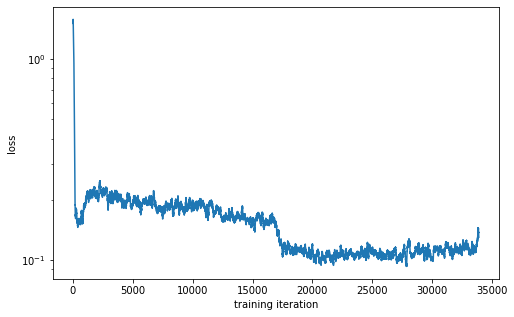

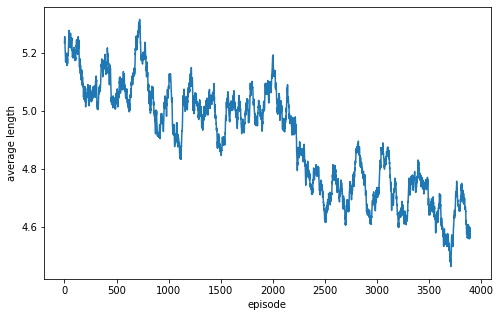

In [5]:
plt.figure(figsize=(8,5))
plt.semilogy(moving_avg(losses, 100))
plt.ylabel('loss')
plt.xlabel('training iteration')

plt.figure(figsize=(8,5))
plt.plot(moving_avg(path_lengths, 100))
plt.ylabel('average length')
plt.xlabel('episode')


### Plot best paths

shortest avg length found: 4.455180238932371


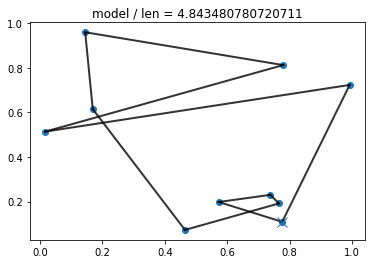

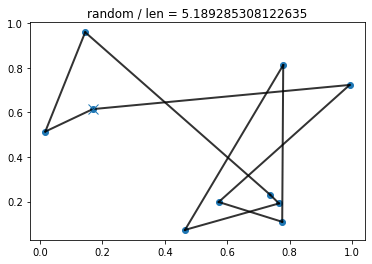

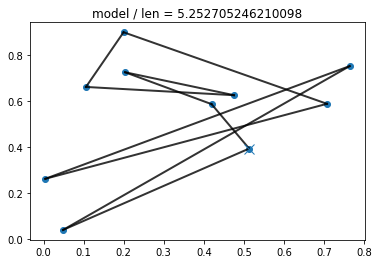

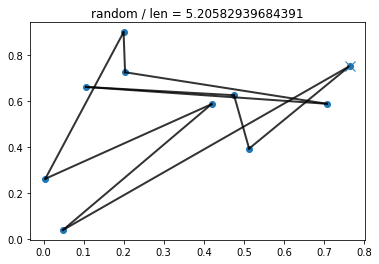

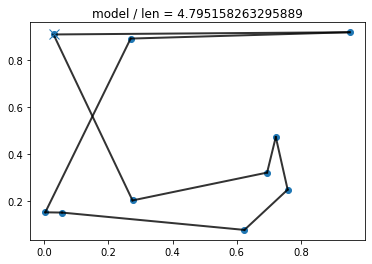

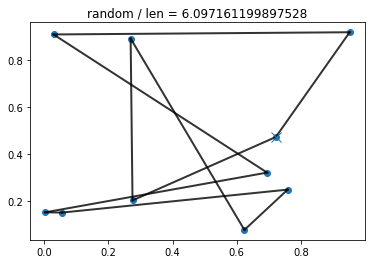

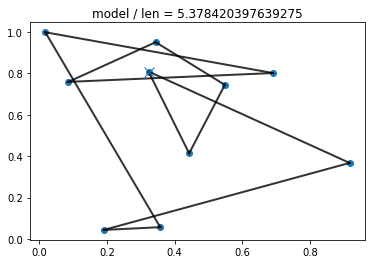

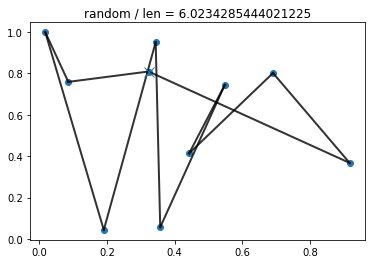

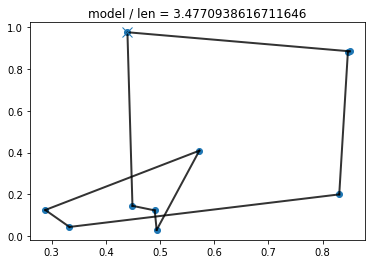

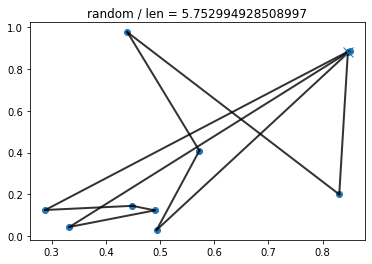

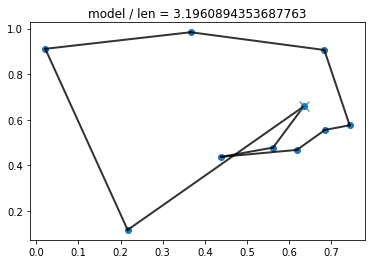

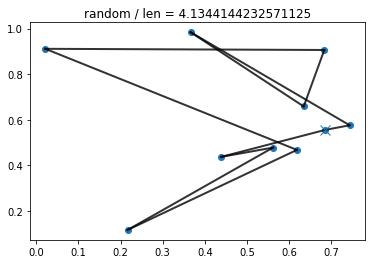

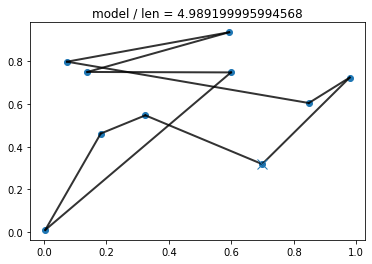

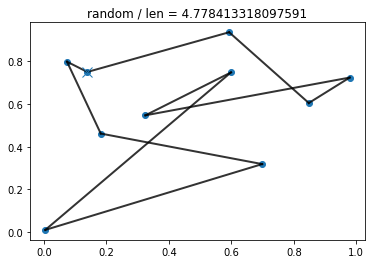

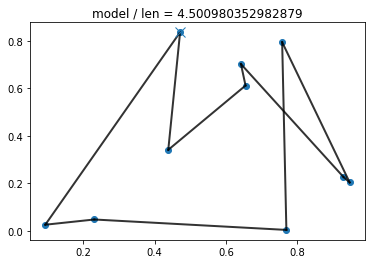

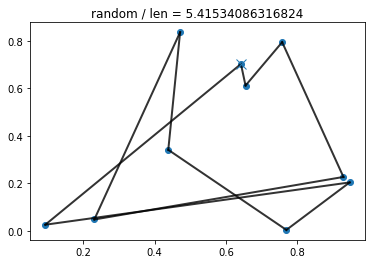

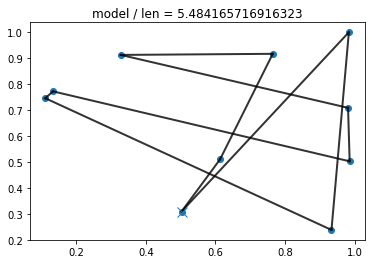

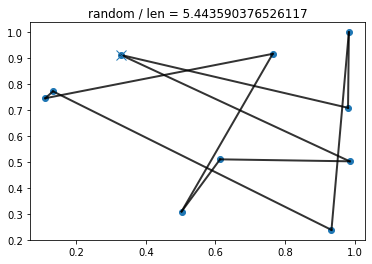

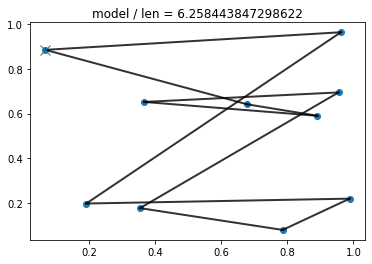

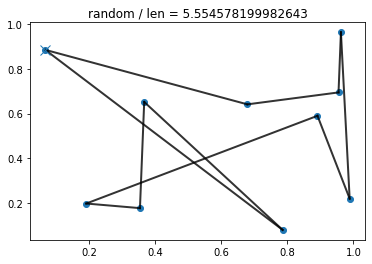

In [6]:
""" Get file with smallest distance
"""
all_lengths_fnames = [f for f in os.listdir(FOLDER_NAME) if f.endswith('.tar')]
shortest_fname = sorted(all_lengths_fnames, key=lambda s: float(s.split('.tar')[0].split('_')[-1]))[0]
print('shortest avg length found: {}'.format(shortest_fname.split('.tar')[0].split('_')[-1]))

""" Load checkpoint
"""
Q_func, Q_net, optimizer, lr_scheduler = init_model(os.path.join(FOLDER_NAME, shortest_fname))

""" A function to plot solutions
"""
def plot_solution(coords, mat, solution):
    plt.scatter(coords[:,0], coords[:,1])
    n = len(coords)

    for idx in range(n-1):
        i, next_i = solution[idx], solution[idx+1]
        plt.plot([coords[i, 0], coords[next_i, 0]], [coords[i, 1], coords[next_i, 1]], 'k', lw=2, alpha=0.8)

    i, next_i = solution[-1], solution[0]
    plt.plot([coords[i, 0], coords[next_i, 0]], [coords[i, 1], coords[next_i, 1]], 'k', lw=2, alpha=0.8)
    plt.plot(coords[solution[0], 0], coords[solution[0], 1], 'x', markersize=10)



""" Generate example solutions
"""
NR_NODES = 10
for sample in range(10):
    coords, W_np = get_graph_mat(n=NR_NODES)
    W = torch.tensor(W_np, dtype=torch.float32, requires_grad=False, device=DEVICE)

    solution = [random.randint(0, NR_NODES-1)]
    current_state = State(partial_solution=solution, W=W, coords=coords)
    current_state_tsr = state2tens(current_state)

    while not is_state_final(current_state):
        next_node, est_reward = Q_func.get_best_action(current_state_tsr,
                                                       current_state)


        solution = solution + [next_node]
        current_state = State(partial_solution=solution, W=W, coords=coords)
        current_state_tsr = state2tens(current_state)

    plt.figure()
    plot_solution(coords, W, solution)
    plt.title('model / len = {}'.format(total_distance(solution, W)))

    # for comparison, plot a random solution
    plt.figure()
    random_solution = list(range(NR_NODES))
    plot_solution(coords, W, random_solution)
    plt.title('random / len = {}'.format(total_distance(random_solution, W)))

